# Part 1- Object Segmentation

The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed and species. Additionally, head bounding boxes are provided for the training split, allowing using this dataset for simple object detection tasks. In the test split, the bounding boxes are empty.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [ ]:
### a) Load the oxford_iiit_pet dataset
# When split is a list of strings, tfds.load returns a list of datasets.
# So, dataset_list will be [train_ds, test_ds] along with the info object.
dataset_list, info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    as_supervised=False,
    with_info=True)

# Access datasets by index from the returned list
train_ds_raw = dataset_list[0]
test_ds_raw = dataset_list[1]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XSB5LE_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XSB5LE_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
def read_and_preprocess(data):
  input_image =  tf.image.resize(data['image'], [128, 128])                              #Resize the data['image'] to 128x128
  input_mask = tf.image.resize(data['segmentation_mask'], [128, 128], method='nearest')  #Resize the data['segmentation_mask'] to 128x128

  # Normalize to [0,1]
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1 # {1,2,3} to {0,1,2}
  input_mask = tf.cast(input_mask, tf.uint8) - 1

  return input_image, input_mask

In [ ]:
train = train_ds_raw.map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = test_ds_raw.map(read_and_preprocess)

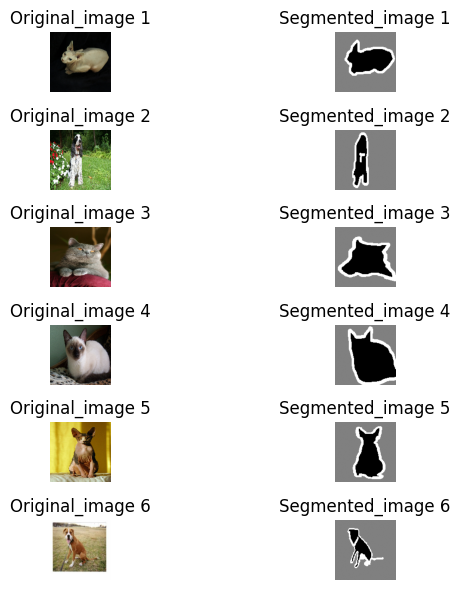

In [ ]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version
sample_images = list(train_ds_raw.take(6))
segmented_samples = [read_and_preprocess(image) for image in sample_images]

plt.figure(figsize=(8, 6))
for i, (img, mask) in enumerate(segmented_samples):
  img = img.numpy()
  img = np.clip(img, 0, 1)
  maks = mask.numpy()

  ## Original image
  plt.subplot(6, 2, 2*i + 1)
  plt.imshow(img)
  plt.title(f"Original_image {i+1}")
  plt.axis('off')

  ## Segmentation mask
  plt.subplot(6, 2, 2*i + 2)
  plt.imshow(mask[:,:,0], cmap='gray')
  plt.title(f"Segmented_image {i+1}")
  plt.axis('off')


plt.tight_layout()
plt.show()


## Part 2- Annotation

In [2]:
### Install mrcnn
! pip install git+https://github.com/matterport/Mask_RCNN.git
! pip install opencv-python
! pip install xmls

  Cloning https://github.com/matterport/Mask_RCNN.git to /tmp/pip-req-build-d9cvgkvl
  Running command git clone --filter=blob:none --quiet https://github.com/matterport/Mask_RCNN.git /tmp/pip-req-build-d9cvgkvl
  Resolved https://github.com/matterport/Mask_RCNN.git to commit 3deaec5d902d16e1daf56b62d5971d428dc920bc
  Preparing metadata (setup.py) ... done
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-py3-none-any.whl size=56920 sha256=4461af1b517c9e0ecc9c2f255764a384a9f89663e16beb45c906e0750021d87d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1l63okqz/wheels/72/4a/32/a93febdcbafe7f8f7b2cb0351b8e3da116ca3c9ad9e5b704f4
Successfully built mask-rcnn
ERROR: Could not find a version that satisfies the requirement xmls (from versions: none)
ERROR: No matching distribution found for xmls


In [55]:
### Get data from here https://github.com/experiencor/raccoon_dataset
!rm -rf raccoon_dataset/
!git clone https://github.com/experiencor/raccoon_dataset.git
!ls -ltr raccoon_dataset/

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Counting objects: 100% (646/646), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 646 (delta 413), reused 643 (delta 412), pack-reused 0 (from 0)
Receiving objects: 100% (646/646), 48.00 MiB | 16.06 MiB/s, done.
Resolving deltas: 100% (413/413), done.
total 2524
-rw-r--r-- 1 root root    1077 Nov 10 13:53  README.md
-rw-r--r-- 1 root root    1064 Nov 10 13:53  LICENSE
-rw-r--r-- 1 root root       0 Nov 10 13:53  __init__.py
drwxr-xr-x 2 root root   12288 Nov 10 13:53  annotations
drwxr-xr-x 2 root root    4096 Nov 10 13:53  data
-rw-r--r-- 1 root root    3331 Nov 10 13:53  generate_tfrecord.py
-rw-r--r-- 1 root root     795 Nov 10 13:53  environment.yml
-rw-r--r-- 1 root root 2494931 Nov 10 13:53 'draw boxes.ipynb'
-rw-r--r-- 1 root root    6184 Nov 10 13:53  test_xml_to_csv.py
-rw-r--r-- 1 root root   14411 Nov 10 13:53  test_generate_tfrecord.py
-rw-r--r-- 1 root root    7131 Nov 

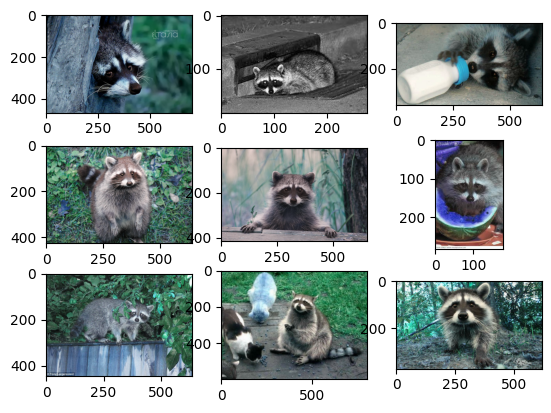

In [ ]:
### Look into data
import os
dataset_dir = 'raccoon_dataset'
image_dir = os.path.join(dataset_dir, "images")

### Plot few images
for i , image_file in enumerate(os.listdir(image_dir)[:9]):
  img = cv2.imread(os.path.join(image_dir, image_file))

  plt.subplot(3,3, i+1)
  plt.imshow(img)

In [10]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file XML ---> tree representation
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


In [5]:
#train_set.image_ids[0]
### load an image
image_id = train_set.image_ids[0]

### Use the function above to create the image and its mask
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)

### Print basic info
print(f"Image Shape: {image.shape}")
print(f"Mask Shape: {mask.shape}")
print(f"Class IDs: {class_ids}")


Image Shape: (467, 700, 3)
Mask Shape: (467, 700, 1)
Class IDs: [1]


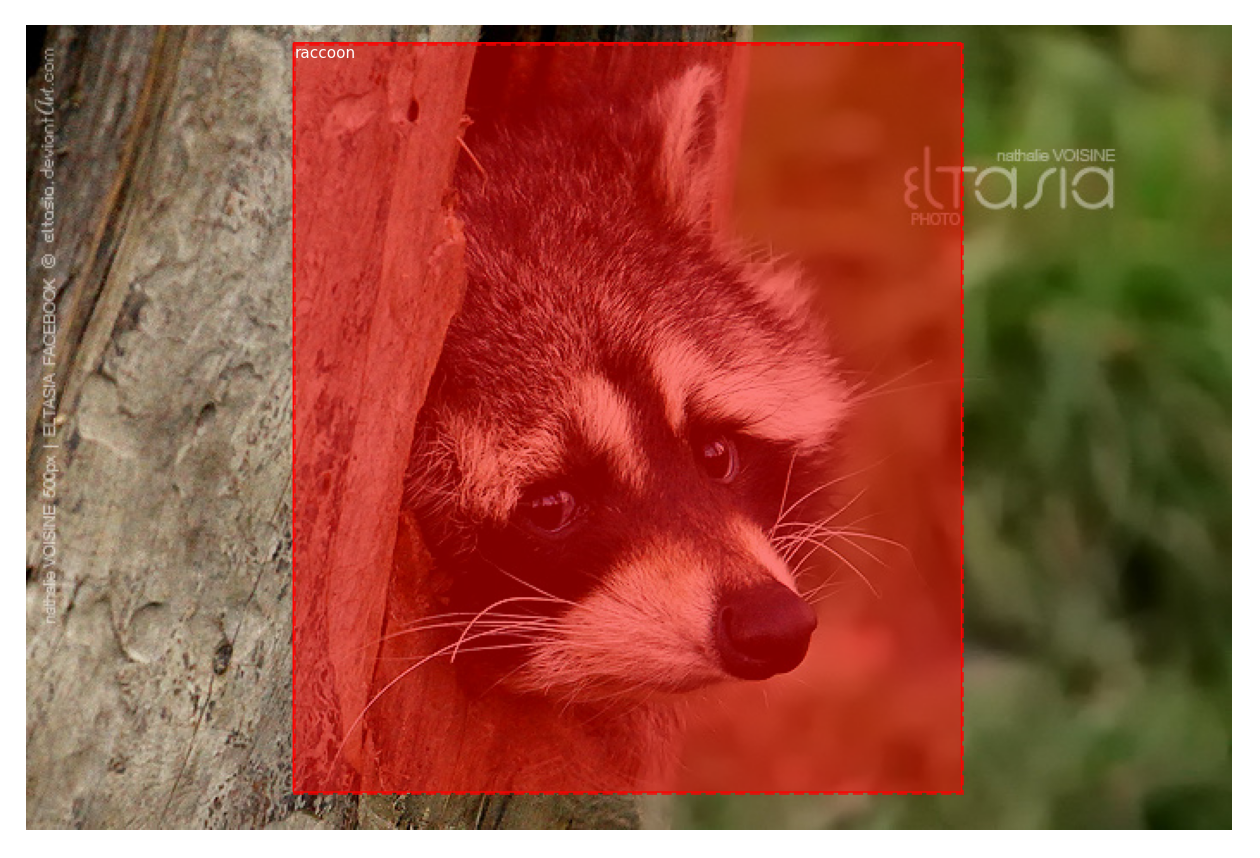

In [6]:
from mrcnn.visualize import display_instances
import numpy as np ### Ensure numpy is imported if not already. It is in the notebook.

### image_id, image, mask, class_ids are already defined from the previous cell.
info = train_set.image_info[image_id]
anotation_path = info['annotation']
raw_boxes, _, _ = train_set.extract_boxes(anotation_path)

### Convert boxes from [xmin, ymin, xmax, ymax] to [y1, x1, y2, x2]
formatted_boxes = []
for box in raw_boxes:
    xmin, ymin, xmax, ymax = box
    formatted_boxes.append([ymin, xmin, ymax, xmax])

display_instances(image, np.array(formatted_boxes), mask, class_ids, train_set.class_names)

**Part 3- YOLO**




You can see how YOLO has been improved in the last few versions on COCO: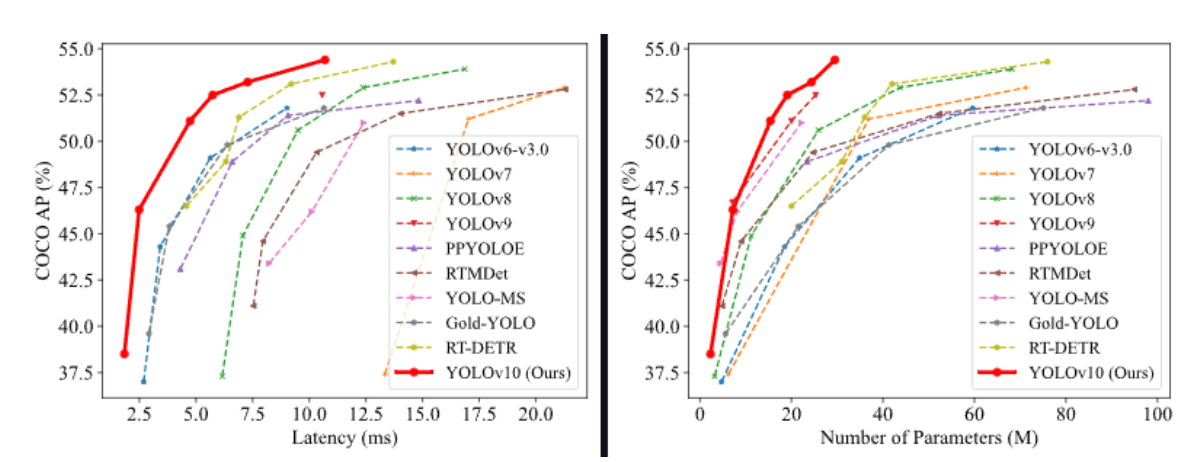

In [ ]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module
# !pip install labelImg
# !labelImg
### Installed the labelImg on workstation and uploaded few files.
### also used annotation.html

#### Download yolov10

In [84]:
#b- Download required tools
# Install the required packages.
import os
import sys
HOME = os.getcwd()
!pip install -q git+https://github.com/THU-MIG/yolov10.git

# !rm -rf {HOME}/yolov10/
# #!pip install -q git+https://github.com/THU-MIG/yolov10.git
# !git clone https://github.com/THU-MIG/yolov10.git {HOME}/yolov10
# HOME = os.getcwd()
# sys.path.append(f"{HOME}/yolov10")
# !ls {HOME}/yolov10

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [85]:
# ## Load pretrained weights
!rm -rf {HOME}/weights
!mkdir -p {HOME}/weights/
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights/


total 32M
-rw-r--r-- 1 root root 32M May 26  2024 yolov10s.pt


In [63]:
# !python --version
# !pip install ultralytics

#### Test the YOLO Model


image 1/1 /content/raccoon_dataset/images/raccoon-1.jpg: 416x640 1 cat, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Results saved to /content/runs/detect/predict
Box coordinates: 84.08074951171875, 104.53878784179688, 517.8740844726562, 405.22613525390625
Class ID: 15, Confidence: 0.91


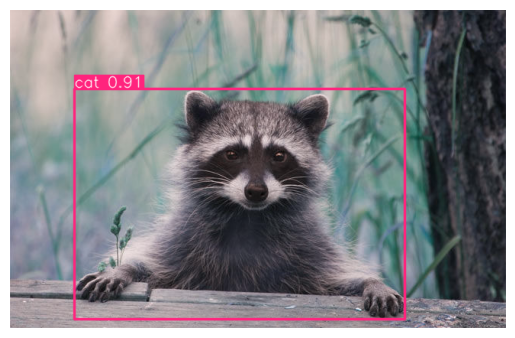

In [86]:
### Test the Model Out of the box
### YOLO useage Reference :
### https://docs.ultralytics.com/guides/yolo-common-issues/#understanding-precision-metrics-in-yolo11
### https://huggingface.co/jameslahm/yolov10s

from ultralytics import YOLO
#model=YOLO('yolo10s.pt')
model=YOLO('weights/yolov10s.pt')

# Load the YOLOv10 model from the locally downloaded weights
#model = YOLOv10(f'{HOME}/weights/yolo11n.pt', weights_only=True)

yolo_results = model.predict(source="raccoon_dataset/images/raccoon-1.jpg", save=True, imgsz=640)

result = yolo_results[0]

### Print box coordinates
for box in result.boxes.xyxy:  # bounding boxes
    x1, y1, x2, y2 = box
    print(f"Box coordinates: {x1}, {y1}, {x2}, {y2}")

for cls, conf in zip(result.boxes.cls, result.boxes.conf):  # class and confidence
    print(f"Class ID: {int(cls)}, Confidence: {conf:.2f}")

# Plot the results and get the annotated image as Numpy arrya
annotated_img = result.plot()

# Save the image
save_path = "yolo_results/images/raccoon-1.jpg"
cv2.imwrite(save_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))

### Show the image
plt.imshow(annotated_img)
plt.axis('off')
plt.show()



### D - Fine tune the model

In [87]:
#### Split the dataaset into raccoon_dataset_split/train/ and raccoon_dataset_split/val for training and validation.
import os
import glob
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

# Define paths
DATASET_DIR = 'raccoon_dataset'
IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(DATASET_DIR, 'annotations')
YOLO_DATASET_DIR = 'raccoon_dataset_split'

# Create YOLO format dataset directories
os.makedirs(os.path.join(YOLO_DATASET_DIR, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_DIR, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_DIR, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_DIR, 'val', 'labels'), exist_ok=True)

# Get list of all image and annotation files
image_files = sorted(glob.glob(os.path.join(IMAGES_DIR, '*.jpg')))
annotation_files = sorted(glob.glob(os.path.join(ANNOTATIONS_DIR, '*.xml')))

# Ensure every image has a corresponding annotation and vice-versa
image_names = {os.path.splitext(os.path.basename(f))[0].replace('raccoon-', '') for f in image_files}
anotation_names = {os.path.splitext(os.path.basename(f))[0].replace('raccoon-', '') for f in annotation_files}

common_names = list(image_names.intersection(anotation_names))

# Filter files to ensure consistency
filtered_image_files = [os.path.join(IMAGES_DIR, f'raccoon-{name}.jpg') for name in common_names]
filtered_annotation_files = [os.path.join(ANNOTATIONS_DIR, f'raccoon-{name}.xml') for name in common_names]

print(f"Found {len(filtered_image_files)} consistent image/annotation pairs.")

# Split data into training and validation sets
train_images, val_images, train_annotations, val_annotations = train_test_split(
    filtered_image_files, filtered_annotation_files, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

# Function to convert XML to YOLO format
def convert_xml_to_yolo(xml_file, output_dir, class_list):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    img_w = int(size.find('width').text)
    img_h = int(size.find('height').text)

    yolo_labels = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_list: # Skip if class not defined
          continue
        class_id = class_list.index(class_name)
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Convert to YOLO format (normalized cx cy w h)
        x_center = (xmin + xmax) / (2 * img_w)
        y_center = (ymin + ymax) / (2 * img_h)
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Save YOLO label file
    output_label_path = os.path.join(output_dir, os.path.basename(xml_file).replace('.xml', '.txt'))
    with open(output_label_path, 'w') as f:
        for line in yolo_labels:
            f.write(line + '\n')

# Define the class list based on the dataset
class_list = ['raccoon']

# Copy and convert for training set
print("\nCopying and converting training data...")
for img_path, ann_path in zip(train_images, train_annotations):
    img_name = os.path.basename(img_path)
    shutil.copy(img_path, os.path.join(YOLO_DATASET_DIR, 'train', 'images', img_name))
    convert_xml_to_yolo(ann_path, os.path.join(YOLO_DATASET_DIR, 'train', 'labels'), class_list)

# Copy and convert for validation set
print("Copying and converting validation data...")
for img_path, ann_path in zip(val_images, val_annotations):
    img_name = os.path.basename(img_path)
    shutil.copy(img_path, os.path.join(YOLO_DATASET_DIR, 'val', 'images', img_name))
    convert_xml_to_yolo(ann_path, os.path.join(YOLO_DATASET_DIR, 'val', 'labels'), class_list)

print("Dataset prepared in YOLO format.")

Found 200 consistent image/annotation pairs.
Training images: 160
Validation images: 40

Copying and converting training data...
Copying and converting validation data...
Dataset prepared in YOLO format.


Now that the data is split and annotations are converted, I'll create the `data.yaml` file. This file tells YOLOv10 where to find your training and validation images, how many classes you have, and the names of those classes.

In [88]:
# data: Specifies the path to your data.yaml file, which defines the dataset location and class information.
# epochs: Sets the number of times the model will iterate over the entire training dataset (50 in this case).
# imgsz: Defines the input image size for training (60x60 pixels). The system might adjust this to a multiple of 32 for optimal performance, as seen in the output.
# batch: The number of images processed at once during training (16 images per batch).
# lr0: The initial learning rate for the optimizer. This controls how much the model's weights are adjusted during each training step.
# save: If True, the trained model's weights (last.pt and best.pt) will be saved.

yolo_results = model.train(
    data="raccoon_dataset_split/data.yaml",
    epochs=50,
    imgsz=60,
    batch=16,
    lr0=0.0001,
    save=True
)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=raccoon_dataset_split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=60, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=weights/yolov10s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

In [89]:
trained_model=YOLO('/content/runs/detect/train/weights/best.pt')
prediction = trained_model.predict(source="raccoon_dataset/images/raccoon-1.jpg", save=True)


image 1/1 /content/raccoon_dataset/images/raccoon-1.jpg: 64x64 2 raccoons, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)
Results saved to /content/runs/detect/predict2


Box coordinates: 187.81015014648438, 91.78240966796875, 514.5813598632812, 377.51995849609375
Box coordinates: 123.0375747680664, 86.29801940917969, 489.06878662109375, 383.27020263671875
Class ID: 0, Confidence: 0.73
Class ID: 0, Confidence: 0.43


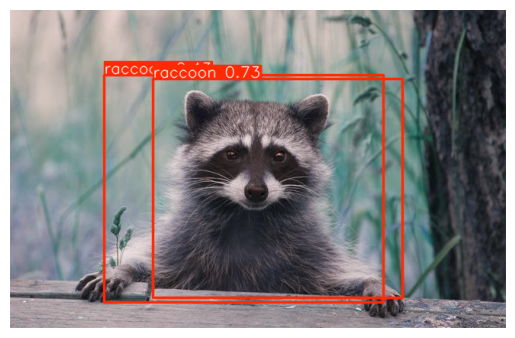

In [90]:
result = prediction[0]

### Print box coordinates
for box in result.boxes.xyxy:  # bounding boxes
    x1, y1, x2, y2 = box
    print(f"Box coordinates: {x1}, {y1}, {x2}, {y2}")

for cls, conf in zip(result.boxes.cls, result.boxes.conf):  # class and confidence
    print(f"Class ID: {int(cls)}, Confidence: {conf:.2f}")

# Plot the results and get the annotated image as Numpy arrya
annotated_img = result.plot()

# Save the image
save_path = "/content/runs/detect/predict2/raccoon-1.jpg"
cv2.imwrite(save_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))

### Show the image
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

# e - Explain what you see in the learning curves and confusion matrix.

#### Learning Curve

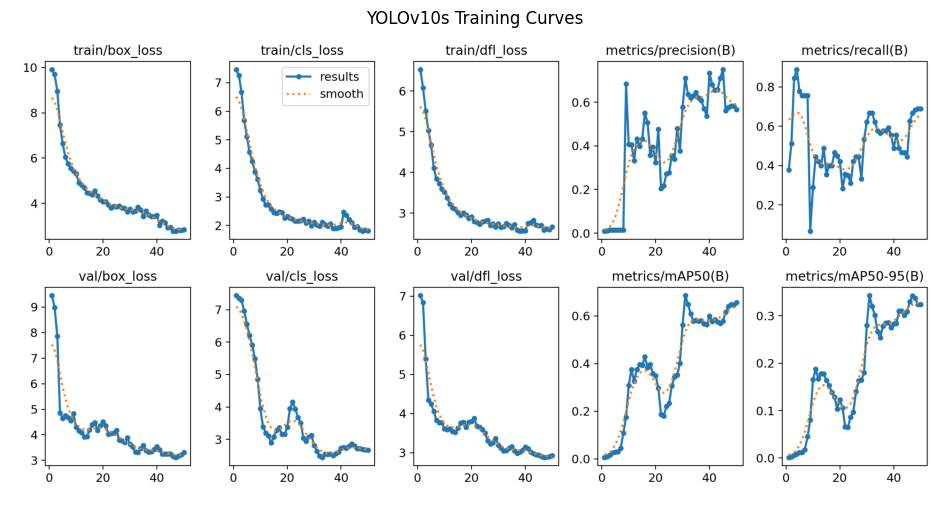

In [94]:
results_path = "/content/runs/detect/train/results.png"
img = plt.imread(results_path)
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.axis('off')
plt.title("YOLOv10s Training Curves")
plt.show()

**Learning curve:**
- train/box_loss = The model is able learn racoon shapes and positions effectively.
- train/cls_loss(classification loss) = shows the loss drops from 7 to less than 2.
- train/dfl_loss(Distribution focal loss) = Relates to bounding box quality. Decresaed from 6 to 2:
- All training losses are decreasing smoothly with number of epochs.
- Metrics/precision(B) ==> Model correctly predicting the boxes.(~0.7)
- Metrics/recall (B) ==> How many true raccoons were detected. fluctuates between 0.3 to 0.8.
- metrics/mAP50(B) => 0.6
- metrics/mAP95(B) ==> 0.3 , indicates the model is achiveving decent accuracy for a small single class dataset.
- validation loss also reduces with the epochs from 9 to 3.


#### Evaluate model performance on validation data

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1251.2±582.1 MB/s, size: 52.7 KB)
val: Scanning /content/raccoon_dataset_split/val/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 40/40 72.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 5.3it/s 0.6s
                   all         40         45      0.698      0.644      0.701      0.349
Speed: 1.6ms preprocess, 7.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /content/runs/detect/val


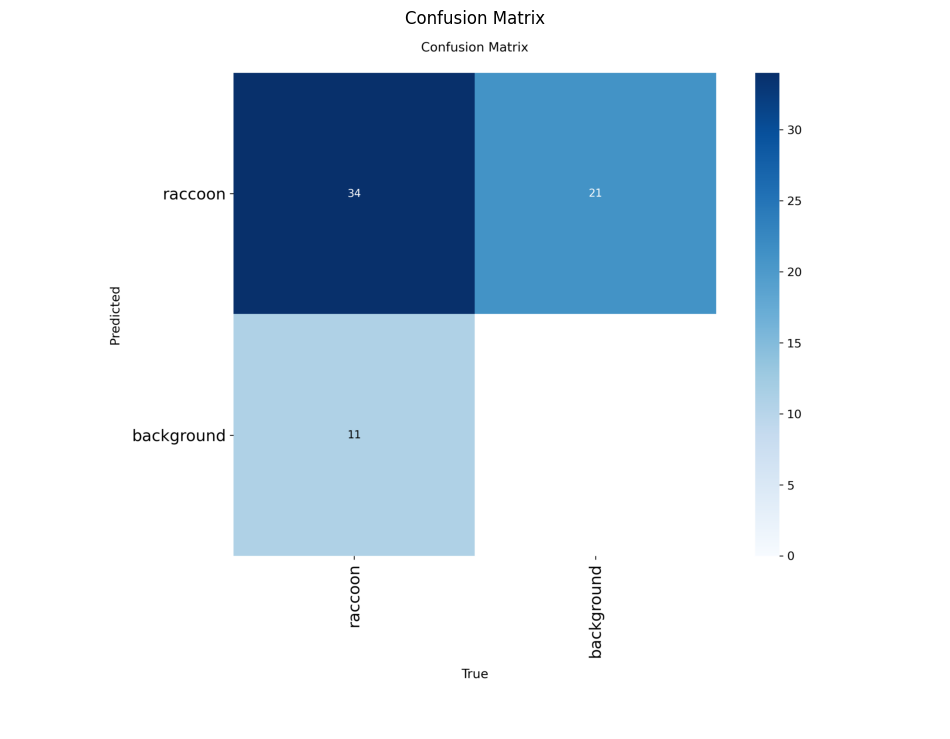

In [93]:
# Evaluate model performance on validation data
metrics = model.val()

# Plot confusion matrix
conf_matrix = '/content/runs/detect/train/confusion_matrix.png'
img = plt.imread(conf_matrix)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.title("Confusion Matrix")
plt.show()


**Confusion Matrix**
- True positive = 34 . The model correctly detected racoons in 34 images.
- False Positives = 21. The model mistakenly predicted racoons where there were none(miscalssified as racoons).
- False Negative = 11 . Model failed to detect real racoons.
- True Negative = 0 . Model correctly identified if no racoons in the image. as all images has racoons.
- Precision = TP / (TP + FP ) = 0.62 (65%).
- Recall = TP / (TP + FN) = 0.76 (Model found 76% of all raccoons)
- F1 Score = 2 x (Precision * Recall)/(Precision + Recall) = 0.68

- Overall we still fine tune the model by provising more training images with annotations, increase training epochs etc.
